# U-Net3+ - multiple heads, no attention


## Description

**Kaggle mean Intersection over Union** : 0.42

**Local test mean Intersection over Union**: 0.42

**Description**: Using multiple heads on previously trained UNet3+ architecture

**Motivation**: Learning more meaningful features even in the middle of the network, simplifying convergence and allowing better gradient flow

## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 2


## Imports

In [ ]:
# Set seed for reproducibility
seed = 19

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import utils

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import sklearn.utils as skl_utils
import matplotlib.patches as mpatches
from datetime import datetime
from tensorflow.keras.metrics import MeanIoU
from scipy.ndimage import gaussian_filter

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Number of classes
NUM_CLASSES = 5

# Input Shape
INPUT_SHAPE = (64,128,1)

## Load Data

In [ ]:
# Load the dataset
data = np.load("dataset/cleaned_normalized_dataset.npz")

# Split the dataset in images and labels array
X = data['images']
y = data['labels']
X_test = data['test_set']
test_img = data['test_set']

In [ ]:
# Normalize all the data into the 0-1 range
maxv = max(X.max(), X_test.max())
minv = min(X.min(), X_test.min())
X = (X - minv) / (maxv - minv)
X_test = (X_test - minv) / (maxv - minv)

# Convert labels to one-hot
y = tfk.utils.to_categorical(y, num_classes=NUM_CLASSES)

In [ ]:
# Split the dataset into training, test, and validation
train_img, test_img_local, train_lbl, test_lbl_local = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(train_img, train_lbl, test_size=0.2, random_state=seed)

In [ ]:
# A series of augmentation functions

def expand(image, label):
    return tf.expand_dims(image, axis=-1), tf.expand_dims(label, axis=-1)

def squeeze(image, label):
    return tf.squeeze(image, axis=-1), tf.squeeze(label, axis=-1)

# Flips the image and label horizontally.
def flip_lr(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_left_right(image)
    label = tf.reverse(label, axis=[1])
    image, label = squeeze(image, label)
    return image, label

# Flips the image and label vertically.
def flip_ud(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_up_down(image)
    label = tf.reverse(label, axis=[0])
    image, label = squeeze(image, label)
    return image, label

# Change brightness randomly
def random_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return image, label

# Change contrast randomly
def random_contrast(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image = tf.squeeze(image, axis=-1)
    return image, label

In [ ]:
# Random pipeline augmentation
def preprocess(image, label):
    if tf.random.uniform(()) > 0.5:
        image, label = flip_lr(image, label)
    if tf.random.uniform(()) > 0.5:
        image, label = flip_ud(image, label)
    if tf.random.uniform(()) > 0.5:
        image, label = random_contrast(image, label)
    return image, label

In [ ]:
# Create a dataset with batch, augmentations and shuffle
def make_dataset(images,labels,batch_size, shuffle=True, augment=False, seed=None):
    # Convert images and labels to float32
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    #prepar data for training with potentially multiple outputs
    dataset = tf.data.Dataset.from_tensor_slices((images,{'o2':labels, 'o3':labels, 'o4':labels}))

    if augment:
        # Expand the size and applying augmentation
        expansions = 3
        new_dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        for _ in range(expansions-1):
            processed = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            new_dataset = new_dataset.concatenate(processed)
        dataset = new_dataset


    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the training dataset
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

# Create the validation dataset
val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    seed=seed
)

Original training samples shape: (1598, 64, 128)
Number of training samples 1600


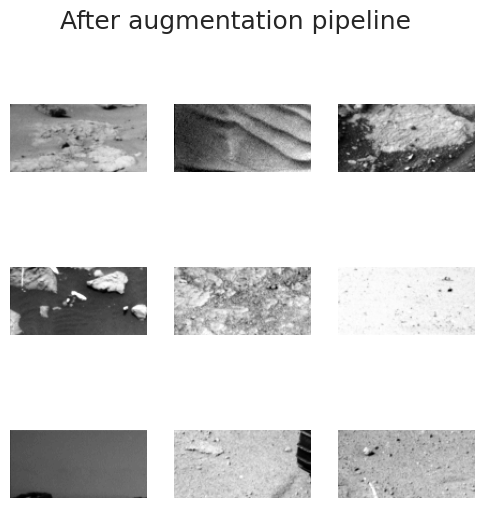

In [ ]:
print("Original training samples shape:", X_train.shape)
print("Number of training samples", len(list(train_dataset))*BATCH_SIZE)

# Print augmented images
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0],cmap='gray')
        plt.axis("off")
    plt.show()

# Visualize the dataset
visualize_dataset(train_dataset, title="After augmentation pipeline")

## Model Implementation

In [ ]:
# Creates an encoder block for the U-Net model.
# Applies two convolutional layers with batch normalization and ReLU activation.

def encoder_block(input,  n_filters, kernel_size, strides, name=''):
    # Not using bias since we are using batch normalization after each layer
    # thus making the bias parameters redundant
    e = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(input)
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    e = tfkl.Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same', use_bias=False)(e)
    e = tfkl.BatchNormalization()(e)
    e = tfkl.Activation('relu')(e)
    return e

In [ ]:
# Takes as input a series of layers to upscale, in order by the last one to the
# first one that has to be upscaled
def upscale_block(inputs):
    n_upscales = len(inputs) #number of input tensors
    upscale_layers = []

    # If we pass [(x,16,32,1), (y,32,64,1)] as input tensors we get [(x+y,64,128,1))]
    # since the first one is upscaled with 2**2 stride and the second one with 2**1
    for i, inp in enumerate(inputs):
        exponent = n_upscales - i
        u = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2**exponent, padding='same')(inp)

        # Each upscaling goes through further convolutions to reduce
        # superfluous information (as the paper says)
        for i in range(2):
            u = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(u)
            u = tfkl.BatchNormalization()(u)
            u = tfkl.Activation('relu')(u)
            u = tfkl.Dropout(rate=0.4)(u)

        upscale_layers.append(u)
    return upscale_layers


In [ ]:
# Creates a decoder block for the U-Net model.
# Upscales features, concatenates with downscaled features,
#  and applies convolutions with batch normalization and ReLU activation.

def decoder_block(inputs_to_upscale, inputs_to_downscale):
    upscaled_layers = upscale_block(inputs_to_upscale)

    decoder_blocks = []

    # Downscales using 2**i strides the layers coming from the encoder part
    # of the network
    for i, inp in enumerate(inputs_to_downscale):
        d = tfkl.Conv2D(filters=64, kernel_size=3, strides=2**i, padding='same', use_bias=False)(inp)
        d = tfkl.BatchNormalization()(d)
        d = tfkl.Activation('relu')(d)
        d = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(d)
        d = tfkl.BatchNormalization()(d)
        d = tfkl.Activation('relu')(d)

        decoder_blocks.append(d)

    dec = tfkl.Concatenate()(upscaled_layers + decoder_blocks)
    dec = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(dec)
    dec = tfkl.BatchNormalization()(dec)
    dec = tfkl.Activation('relu')(dec)
    dec = tfkl.Dropout(rate=0.4)(dec)
    return dec


In [ ]:
# Creates the output head of the U-Net model.
# Applies final convolutions to produce the segmentation predictions.

def head(inputs,name=''):
    h = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(inputs)
    h = tfkl.BatchNormalization()(h)
    h = tfkl.Activation('relu')(h)
    h = tfkl.Conv2D(filters=NUM_CLASSES, kernel_size=1, padding='same', activation='softmax',name=name)(h)
    return h

In [ ]:
# Definition of the model
def get_unet_model():
    inputs = tfkl.Input(shape=INPUT_SHAPE)

    # Downsampling path
    e1 = encoder_block(inputs, n_filters=32, kernel_size=3, strides=2, name='encoder_1')
    e2 = encoder_block(e1, n_filters=64, kernel_size=3, strides=2, name='encoder_2')
    e3 = encoder_block(e2, n_filters=128, kernel_size=3, strides=2, name='encoder_3')

    # Bottleneck
    bottleneck = encoder_block(e3, n_filters=256, kernel_size=3, strides=2, name='bottleneck')

    # Upsampling path
    d1 = decoder_block(inputs_to_upscale=[bottleneck], inputs_to_downscale=[e3, e2, e1])
    d2 = decoder_block(inputs_to_upscale=[bottleneck, d1], inputs_to_downscale=[e2, e1])
    d3 = decoder_block(inputs_to_upscale=[bottleneck, d1, d2], inputs_to_downscale=[e1])
    d4 = decoder_block(inputs_to_upscale=[bottleneck, d1, d2, d3], inputs_to_downscale=[])

    # Outputs
    d2up = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2**2, padding='same')(d2)
    outputs2 = head(d2up,name='o2')

    d3up = tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2**1, padding='same')(d3)
    outputs3 = head(d3up,name='o3')

    outputs4 = head(d4,name='o4')

    return tfk.Model(inputs=inputs, outputs=[outputs2, outputs3, outputs4], name='UNet')

In [ ]:
# Model contruction
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 32, 64, 32)   │          288 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 32, 64, 32)   │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 32, 64, 32)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 32, 64, 32)   │        9,216 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 32, 64, 32)   │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 32, 64, 32)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 16, 32, 64)   │       18,432 │ activation_1[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 16, 32, 64)   │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 16, 32, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 16, 32, 64)   │       36,864 │ activation_2[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 16, 32, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 16, 32, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_4 (Conv2D)      │ (None, 8, 16, 128)   │       73,728 │ activation_3[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_4  │ (None, 8, 16, 128)   │          512 │ conv2d_4[0][0]      │    Y    │
│ (BatchNormalization) 

 Total params: 7,369,263 (28.11 MB)

 Trainable params: 7,359,663 (28.07 MB)

 Non-trainable params: 9,600 (37.50 KB)

## Training

In [ ]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3


# Set early stopping patience threshold
PATIENCE = 10

# Set dynamic LR scheduler patience
LR_PATIENCE = 5

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
# Model compilation with Adam as optimizer and CategoricalFocalCrossentropy as loss functions
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE, weight_decay=1e-5),
    loss={
        'o2': tfk.losses.CategoricalFocalCrossentropy(alpha=2),
        'o3': tfk.losses.CategoricalFocalCrossentropy(alpha=2),
        'o4': tfk.losses.CategoricalFocalCrossentropy(alpha=2)},
    loss_weights={
            'o2': 0.5,
            'o3': 0.5,
            'o4': 1},
    metrics=[
        [tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')],
        [tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')],
        [tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')],
        ])

In [ ]:
# Setup callbacks, implementing early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_o4_meanIoU',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_o4_meanIoU',
    mode='max',
    factor=0.1,
    patience=LR_PATIENCE,
    min_lr=1e-5,
)

# Combine the callbacks into a list
callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - loss: 4.5716 - o2_loss: 0.9556 - o2_meanIoU: 0.1579 - o3_loss: 1.1392 - o3_meanIoU: 0.1498 - o4_loss: 2.4767 - o4_meanIoU: 0.1332 - val_loss: 5.4389 - val_o2_loss: 0.9291 - val_o2_meanIoU: 0.1280 - val_o3_loss: 1.0783 - val_o3_meanIoU: 0.0845 - val_o4_loss: 3.3847 - val_o4_meanIoU: 0.0560 - learning_rate: 0.0010
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 688ms/step - loss: 2.3366 - o2_loss: 0.5836 - o2_meanIoU: 0.2344 - o3_loss: 0.5765 - o3_meanIoU: 0.2448 - o4_loss: 1.1765 - o4_meanIoU: 0.2584 - val_loss: 6.8160 - val_o2_loss: 0.9110 - val_o2_meanIoU: 0.1352 - val_o3_loss: 1.9679 - val_o3_meanIoU: 0.0709 - val_o4_loss: 3.8903 - val_o4_meanIoU: 0.0706 - learning_rate: 0.0010
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 691ms/step - loss: 2.1470 - o2_loss: 0.5450 - o2_meanIoU: 0.2516 - o3_loss: 0.5310 - o3_meanIoU: 0.2793 - o4_loss: 1.0709 - o4_meanIoU: 0.2813 - val_loss: 6.1107 - val_o2_loss: 0.9589 - val_o2_meanIoU: 0.1065 - val_o

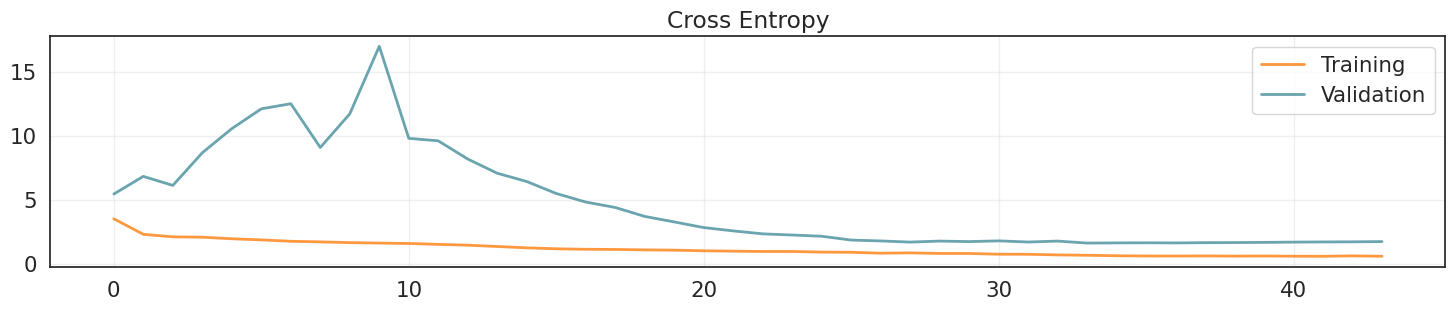

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)[2]
test_predictions = np.argmax(test_predictions, axis=-1)
test_lbl_local = np.argmax(test_lbl_local, axis=-1)

In [ ]:
print(f"Predictions shape: {test_predictions.shape}")
print(f"Labels shape: {test_lbl_local.shape}")

Predictions shape: (500, 64, 128)
Labels shape: (500, 64, 128)


In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted', zero_division=0)
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
test_miou = MeanIoU(NUM_CLASSES)
test_miou.update_state(test_lbl_local, test_predictions)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.6939
Precision score over the test set: 0.6859
Recall score over the test set: 0.6939
F1 score over the test set: 0.6837
Mean Intersection over Union over the test set: 0.42080000042915344


## Save

In [ ]:
# Save the model
from datetime import datetime
current_time = datetime.now().strftime("%d|%m-%H:%M")
model_filename = f'UNet_{current_time}.keras'
print("Saved as :",model_filename)
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet_14|12-16:23.keras


## Submission

In [ ]:
# Predict the masks for the submission
preds = model.predict(test_img)
preds = np.argmax(preds, axis=-1)

In [ ]:
# Converts segmentation predictions into a DataFrame format for Kaggle
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)